In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline
# the above line makes sure the show the graphs in the notebook

data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

!wget $data

!ls


!mv WA_Fn-UseC_-Telco-Customer-Churn.csv data.csv

## Chrun rate prediciton
will be using binary classification

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# df.head().T

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
# df.head().T


In [6]:
# few column types are missinterpretted
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')

In [7]:
df.totalcharges = df.totalcharges.fillna(0)

In [8]:
df.totalcharges.isnull().sum()

np.int64(0)

In [9]:
(df['churn'] == 'yes').astype('int')

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

In [10]:
df.churn = (df['churn'] == 'yes').astype('int')
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

### Setting up validation framework

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

In [13]:
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state = 1)

In [14]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [17]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

### EDA

In [18]:
df_full_train = df_full_train.reset_index(drop=True)

In [19]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [20]:
# df_full_train.churn.value_counts()
df_full_train.churn.value_counts(normalize = True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [21]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate,2)

np.float64(0.27)

In [22]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [23]:
numeric = ['tenure', 'monthlycharges', 'totalcharges']

In [24]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [25]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature importance: Churn Rate and Risk Ratio

#### Churn rate

In [26]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [27]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

np.float64(0.27682403433476394)

In [28]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

np.float64(0.2632135306553911)

In [29]:
global_churn = df_full_train.churn.mean()
global_churn

np.float64(0.26996805111821087)

In [30]:

global_churn - churn_female

np.float64(-0.006855983216553063)

In [31]:
global_churn - churn_male

np.float64(0.006754520462819769)

In [32]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [33]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

np.float64(0.20503330866025166)

In [34]:
global_churn - churn_partner

np.float64(0.06493474245795922)

In [35]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

np.float64(0.3298090040927694)

In [36]:

global_churn - churn_no_partner

np.float64(-0.05984095297455855)

#### Risk ratio

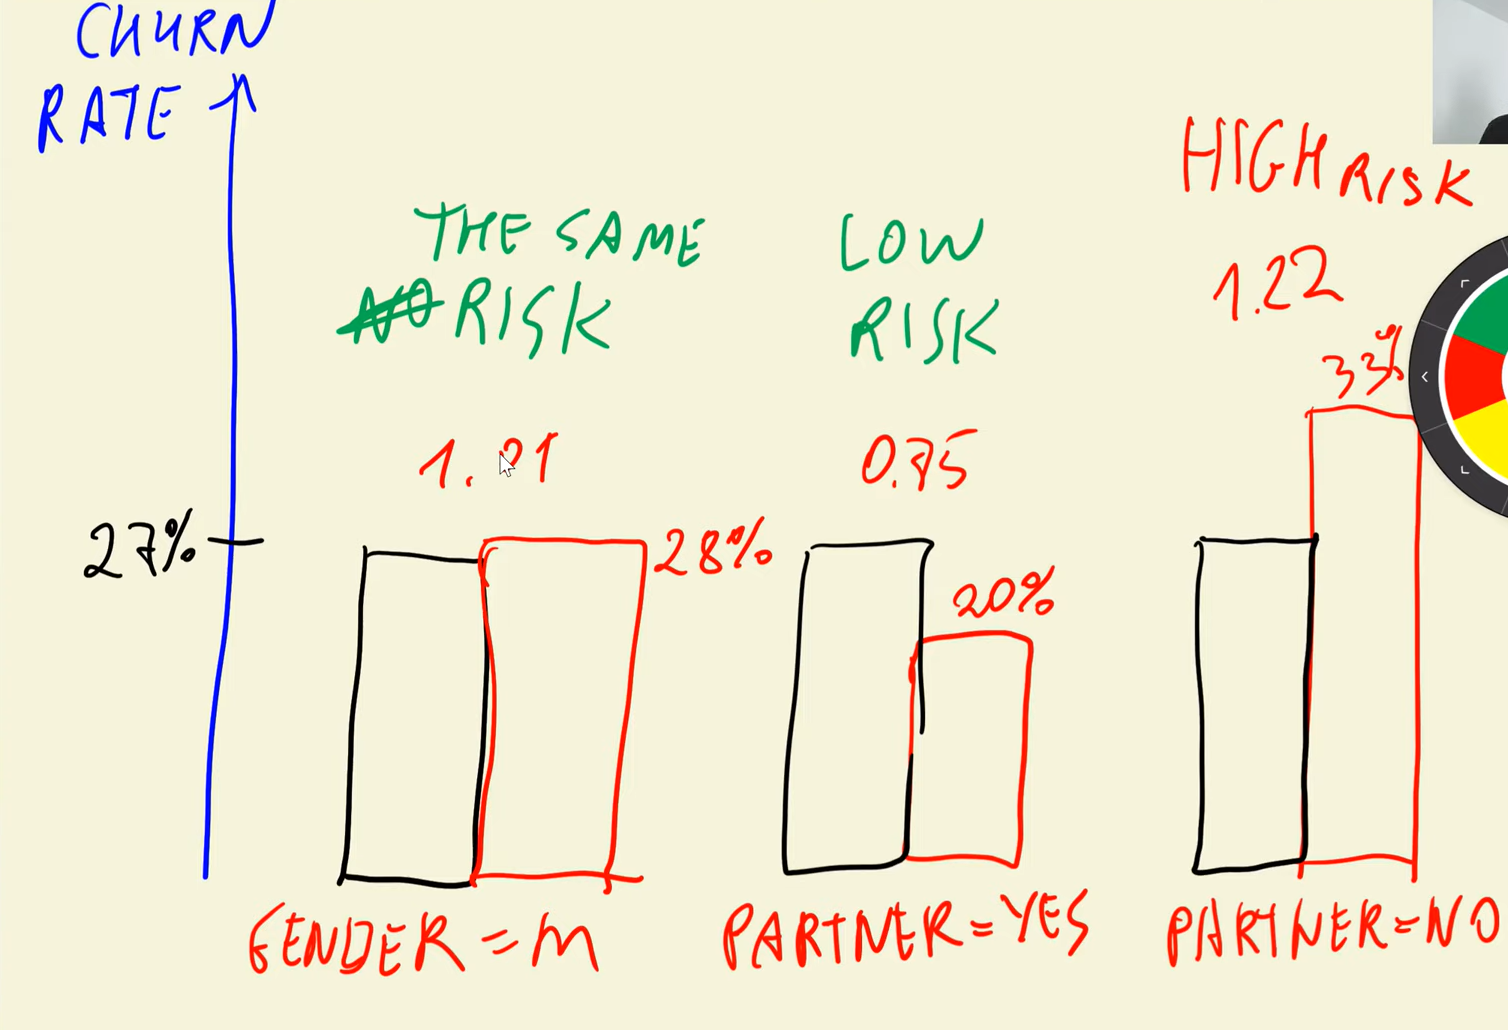

In [37]:
churn_no_partner / global_churn

np.float64(1.2216593879412643)

In [38]:
churn_partner / global_churn

np.float64(0.7594724924338315)

In [39]:
from IPython.display import display

In [40]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980




seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208




partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472




dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651




phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412




multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948




internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201




onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570




onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660




deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480




techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390




streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328




streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182




contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730




paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560




paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


### Feature importance: Mutual information
Mutual information - concept from information theory, it tells us how much we can learn about one variable if we know the value of another

In [41]:
from sklearn.metrics import mutual_info_score

In [42]:
mutual_info_score(df_full_train.churn, df_full_train.gender)

# this means we learn nothing when considering gender

0.0001174846211139946

In [43]:
mutual_info_score(df_full_train.churn, df_full_train.contract)


0.0983203874041556

In [44]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [45]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)

mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

### Feature Importance: Correlation
measure dependency between 2 variables

-1 <= r <= 1
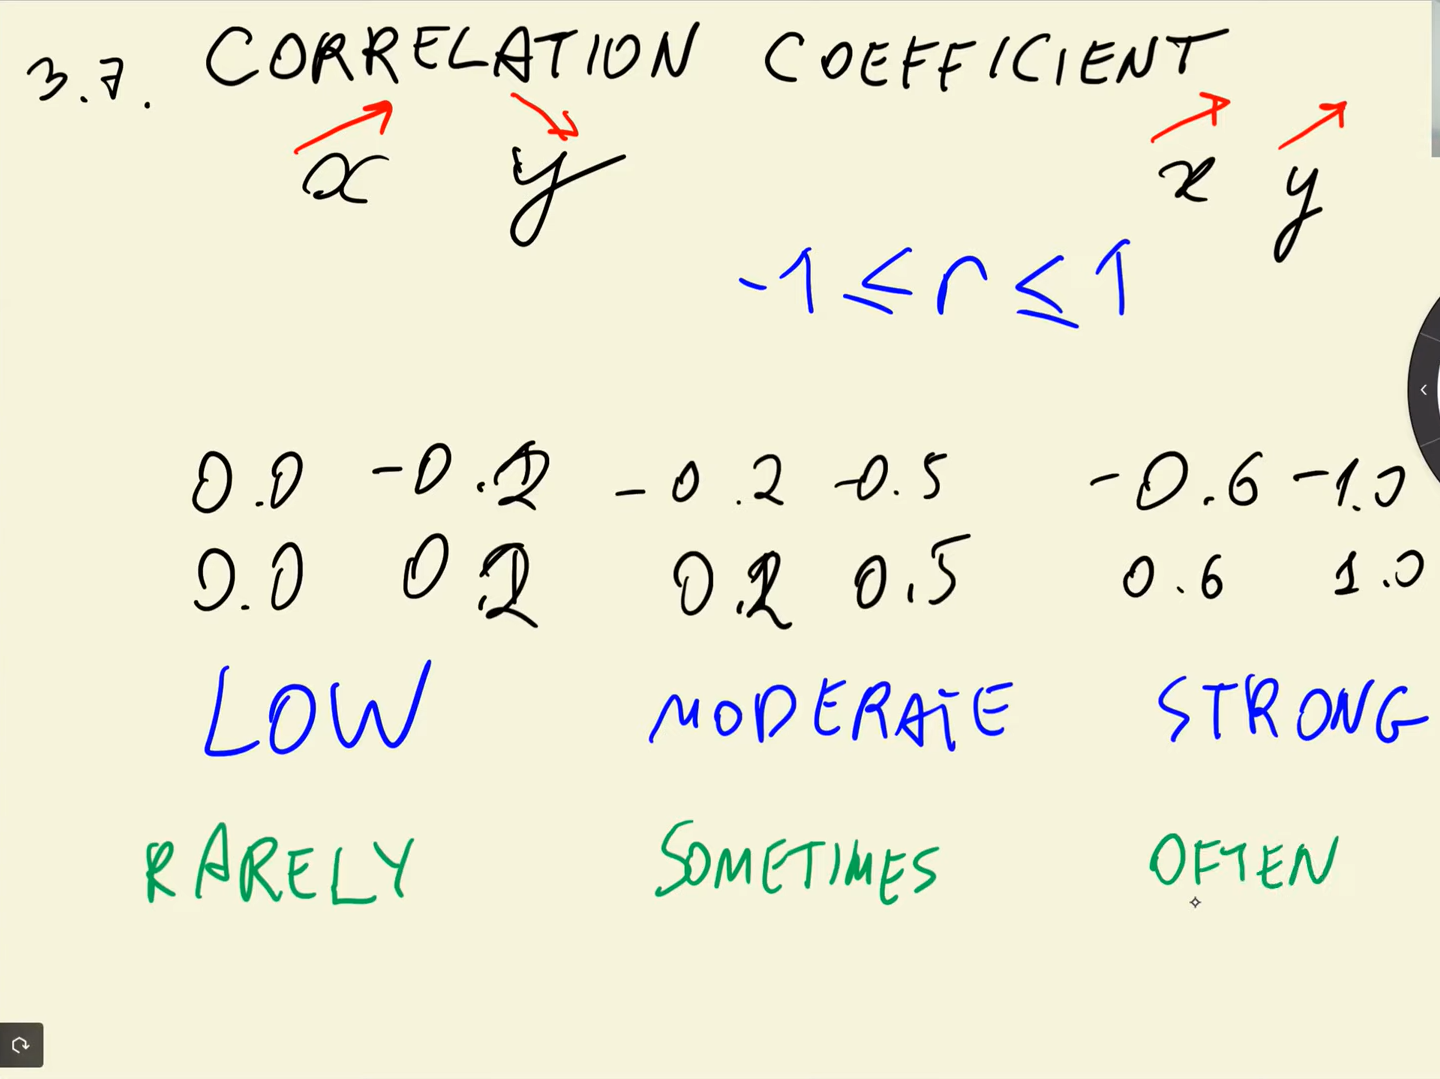

In [46]:
df_full_train[numeric].corrwith(df_full_train.churn)

# negative meaning, with increase in tenure the churn rate descreases

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [47]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [48]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [49]:
df_full_train[df_full_train.tenure > 12].churn.mean()

np.float64(0.17634908339788277)

In [50]:

df_full_train[df_full_train.monthlycharges <= 20].churn.mean()

np.float64(0.08795411089866156)

In [51]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

np.float64(0.18340943683409436)

In [52]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

np.float64(0.32499341585462205)

### One Hot encoding
to encode the categorical features

In [53]:
from sklearn.feature_extraction import DictVectorizer

In [54]:
train_dicts = df_train[categorical + numeric].to_dict(orient='records')

In [55]:
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [56]:
dv = DictVectorizer(sparse=False)

In [57]:
dv.fit(train_dicts)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [58]:
# dv.get_feature_names_out()

In [59]:
# list(dv.transform(train_dicts[:5])[0])

In [60]:
# we can fit and transform together
X_train = dv.fit_transform(train_dicts)
X_train.shape

(4225, 45)

In [61]:
val_dicts = df_val[categorical + numeric].to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Logistic Regression
Logistic and Linear reg both are called as linear models

In [62]:
def sigmoid(z):
    return 1/ (1 + np.exp(-z))

In [63]:
z = np.linspace(-7, 7, 51)
z

array([-7.0000000e+00, -6.7200000e+00, -6.4400000e+00, -6.1600000e+00,
       -5.8800000e+00, -5.6000000e+00, -5.3200000e+00, -5.0400000e+00,
       -4.7600000e+00, -4.4800000e+00, -4.2000000e+00, -3.9200000e+00,
       -3.6400000e+00, -3.3600000e+00, -3.0800000e+00, -2.8000000e+00,
       -2.5200000e+00, -2.2400000e+00, -1.9600000e+00, -1.6800000e+00,
       -1.4000000e+00, -1.1200000e+00, -8.4000000e-01, -5.6000000e-01,
       -2.8000000e-01,  8.8817842e-16,  2.8000000e-01,  5.6000000e-01,
        8.4000000e-01,  1.1200000e+00,  1.4000000e+00,  1.6800000e+00,
        1.9600000e+00,  2.2400000e+00,  2.5200000e+00,  2.8000000e+00,
        3.0800000e+00,  3.3600000e+00,  3.6400000e+00,  3.9200000e+00,
        4.2000000e+00,  4.4800000e+00,  4.7600000e+00,  5.0400000e+00,
        5.3200000e+00,  5.6000000e+00,  5.8800000e+00,  6.1600000e+00,
        6.4400000e+00,  6.7200000e+00,  7.0000000e+00])

In [64]:
sigmoid(z)

array([9.11051194e-04, 1.20508423e-03, 1.59386223e-03, 2.10780106e-03,
       2.78699622e-03, 3.68423990e-03, 4.86893124e-03, 6.43210847e-03,
       8.49286285e-03, 1.12064063e-02, 1.47740317e-02, 1.94550846e-02,
       2.55807883e-02, 3.35692233e-02, 4.39398154e-02, 5.73241759e-02,
       7.44679452e-02, 9.62155417e-02, 1.23467048e-01, 1.57095469e-01,
       1.97816111e-01, 2.46011284e-01, 3.01534784e-01, 3.63547460e-01,
       4.30453776e-01, 5.00000000e-01, 5.69546224e-01, 6.36452540e-01,
       6.98465216e-01, 7.53988716e-01, 8.02183889e-01, 8.42904531e-01,
       8.76532952e-01, 9.03784458e-01, 9.25532055e-01, 9.42675824e-01,
       9.56060185e-01, 9.66430777e-01, 9.74419212e-01, 9.80544915e-01,
       9.85225968e-01, 9.88793594e-01, 9.91507137e-01, 9.93567892e-01,
       9.95131069e-01, 9.96315760e-01, 9.97213004e-01, 9.97892199e-01,
       9.98406138e-01, 9.98794916e-01, 9.99088949e-01])

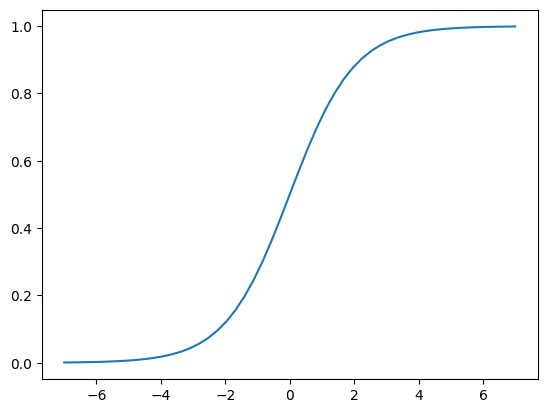

In [65]:
plt.plot(z, sigmoid(z))

In [66]:
# def linear_regression(xi):
#     result = w0
    
#     for j in range(len(w)):
#         result = result + xi[j] * w[j]
        
#     return result

def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
        
    result = sigmoid(score)
    return result

### Training Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [69]:
# the bais -> w0
model.intercept_

array([-0.11092874])

In [70]:
# the weights -> w1,w2...
model.coef_[0].round(3)

array([ 0.564, -0.154, -0.519, -0.013, -0.095,  0.071, -0.098, -0.082,
       -0.033, -0.076, -0.354,  0.343, -0.098,  0.002, -0.251,  0.162,
       -0.02 ,  0.066, -0.098, -0.076,  0.251, -0.098, -0.261, -0.228,
        0.119, -0.121,  0.012, -0.095, -0.03 ,  0.045, -0.028,  0.162,
       -0.271,  0.221, -0.097, -0.098,  0.087, -0.05 , -0.098,  0.039,
        0.194, -0.098, -0.205, -0.072,  0.   ])

In [71]:
model.predict(X_train)

array([0, 1, 1, ..., 1, 0, 1], shape=(4225,))

In [72]:
model.predict(X_train)
# This is called hard predictions, because it directly gives churned or not

array([0, 1, 1, ..., 1, 0, 1], shape=(4225,))

In [73]:
model.predict_proba(X_train)
# these are soft prediction, probability. 2 columns because, first is the probability of how close it is to 0 
# and second is how close it is to 1

array([[0.91088688, 0.08911312],
       [0.33128828, 0.66871172],
       [0.36229559, 0.63770441],
       ...,
       [0.48776317, 0.51223683],
       [0.96993479, 0.03006521],
       [0.2971009 , 0.7028991 ]], shape=(4225, 2))

In [74]:
y_pred = model.predict_proba(X_val)[:, 1]

In [75]:
y_pred

array([0.00786347, 0.20992803, 0.2237105 , ..., 0.15014869, 0.77668113,
       0.81035774], shape=(1409,))

In [77]:
churn_decision = (y_pred>=0.5)

In [80]:
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

In [ ]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1], shape=(1409,))

In [81]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [85]:
df_pred

,probability,prediction,actual,correct
0,0.007863,0,0,True
1,0.209928,0,0,True
2,0.223710,0,0,True
3,0.561123,1,1,True
4,0.219586,0,0,True
...,...,...,...,...
1404,0.297790,0,0,True
1405,0.035463,0,1,False
1406,0.150149,0,0,True
1407,0.776681,1,1,True


In [83]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [84]:
df_pred.correct.mean()

np.float64(0.801277501774308)

### Model interpretation

In [86]:
model.coef_[0].round(3)

array([ 0.564, -0.154, -0.519, -0.013, -0.095,  0.071, -0.098, -0.082,
       -0.033, -0.076, -0.354,  0.343, -0.098,  0.002, -0.251,  0.162,
       -0.02 ,  0.066, -0.098, -0.076,  0.251, -0.098, -0.261, -0.228,
        0.119, -0.121,  0.012, -0.095, -0.03 ,  0.045, -0.028,  0.162,
       -0.271,  0.221, -0.097, -0.098,  0.087, -0.05 , -0.098,  0.039,
        0.194, -0.098, -0.205, -0.072,  0.   ])

In [88]:
list(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

[('contract=month-to-month', np.float64(0.564)),
 ('contract=one_year', np.float64(-0.154)),
 ('contract=two_year', np.float64(-0.519)),
 ('dependents=no', np.float64(-0.013)),
 ('dependents=yes', np.float64(-0.095)),
 ('deviceprotection=no', np.float64(0.071)),
 ('deviceprotection=no_internet_service', np.float64(-0.098)),
 ('deviceprotection=yes', np.float64(-0.082)),
 ('gender=female', np.float64(-0.033)),
 ('gender=male', np.float64(-0.076)),
 ('internetservice=dsl', np.float64(-0.354)),
 ('internetservice=fiber_optic', np.float64(0.343)),
 ('internetservice=no', np.float64(-0.098)),
 ('monthlycharges', np.float64(0.002)),
 ('multiplelines=no', np.float64(-0.251)),
 ('multiplelines=no_phone_service', np.float64(0.162)),
 ('multiplelines=yes', np.float64(-0.02)),
 ('onlinebackup=no', np.float64(0.066)),
 ('onlinebackup=no_internet_service', np.float64(-0.098)),
 ('onlinebackup=yes', np.float64(-0.076)),
 ('onlinesecurity=no', np.float64(0.251)),
 ('onlinesecurity=no_internet_service

In [89]:
small = ['contract', 'tenure', 'monthlycharges']

In [90]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [91]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [92]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [93]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [94]:
X_train_small = dv_small.transform(dicts_train_small)

In [95]:
model_small = LogisticRegression(solver='lbfgs')
model_small.fit(X_train_small, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [96]:
w0 = model_small.intercept_[0]
w0

np.float64(-2.477957595829565)

In [97]:
w = model_small.coef_[0]
w.round(3)

array([ 0.971, -0.024, -0.948,  0.027, -0.036])

In [98]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

In [99]:
-2.47 + (-0.949) + 30 * 0.027 + 24 * (-0.036)

-3.473

In [100]:
sigmoid(_)

np.float64(0.030090303318277657)

### Using the model

In [102]:
dicts_full_train = df_full_train[categorical + numeric].to_dict(orient='records')

In [103]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [104]:
y_full_train = df_full_train.churn.values

In [105]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [107]:
dicts_test = df_test[categorical + numeric].to_dict(orient='records')

In [108]:
X_test = dv.transform(dicts_test)

In [109]:
y_pred = model.predict_proba(X_test)[:, 1]

In [110]:
churn_decision = (y_pred >= 0.5)

In [111]:
(churn_decision == y_test).mean()

np.float64(0.8140525195173882)

In [112]:
y_test

array([0, 0, 0, ..., 0, 0, 1], shape=(1409,))

In [113]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [114]:
X_small = dv.transform([customer])

In [115]:
model.predict_proba(X_small)[0, 1]

np.float64(0.6613470087309817)

In [116]:
y_test[-1]

np.int64(1)

# 3.13 Summary
- Feature importance - risk, mutual information, correlation
- One-hot encoding can be implemented with DictVectorizer
- Logistic regression - linear model like linear regression
- Output of log reg - probability
- Interpretation of weights is similar to linear regression